In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from typing import List

# RESULTS_DIR = "/Midgard/home/martinig/thesis-src/results"
RESULTS_PATH = "/home/martin/Documents/Education/Master/thesis/project/thesis-src/results"
PLOTS_PATH = "/home/martin/Documents/Education/Master/thesis/project/thesis-src/plots/explore-k"

In [ ]:
def load_csv(csv_path: str, without_lexicon: str) -> pd.DataFrame:
	df = pd.read_csv(csv_path)
	df = df[df.Lexicon != without_lexicon]
	return df

In [ ]:
def plot_j_vs_k_vs_lexicon(df, filename, title):
    # Set the style to darkgrid
    sns.set_style("darkgrid")

    # Get the number of lexicons
    n_lexicons = len(df.Lexicon.unique())

    # Create a figure with subplots
    fig, axs = plt.subplots(1, n_lexicons, figsize=(4 * n_lexicons, 4))
    if title:
        fig.suptitle(t=title)

    # Plot the data for each lexicon
    grouped_df = df.groupby(['Lexicon'])
    for i, (lexicon_name, sub_df) in enumerate(grouped_df):
        j_values, k_values = sub_df.J.to_list(), sub_df.K.to_list()
        max_j = max(j_values)
        sns.lineplot(ax=axs[i], data=j_values,  linestyle="--", marker="o")
        axs[i].set(title=lexicon_name, ylabel='J', xlabel='K')
        axs[i].set_xticks(range(len(k_values)), k_values)
        for k, j in enumerate(j_values):
            if j == max_j:
                axs[i].text(x=k, y=j, s=round(j, 3), ha='center', va='bottom', color="green")


    # Adjust the space between subplots
    plt.subplots_adjust(wspace=0.4)

    # Show the plot
    plt.savefig(filename)

In [60]:
def plot_metric_vs_k_vs_model(metrics: List[str], frames: List[pd.DataFrame], baseline_df: pd.DataFrame, title: str, save_path: str = None, palette: dict = None):
	df = pd.concat(frames)

	fig, axs = plt.subplots(1, len(metrics), figsize=(10 * len(metrics), 5))
	if not save_path:
		fig.suptitle(title)
	
	for i, metric in enumerate(metrics):
		for model_idx, model in enumerate(df['Model'].unique()):
			model_df = df[df['Model'] == model]
			color = list(palette.values())[model_idx]
			g = sns.boxplot(
				ax=axs[i] if isinstance(axs, np.ndarray) else axs,
				x='K', y=metric, data=model_df, hue="Model", 
				showmeans=True, showcaps=True, showfliers=False,
				palette=palette,
				meanprops={
					"marker": "+",
					"markeredgecolor": color,
					"alpha": 0.5
				},
				medianprops={
					"alpha": 0.2,
					"color": color,
				},
				boxprops={
					"alpha": 0.3,
					"facecolor": "none",
					"edgecolor": color,
				},
				whiskerprops={
					"alpha": 0.2,
					"color": color,
				},
				capprops={
					"alpha": 0.2,
					"color": color,
				}
			)

		# Line plot of averages
		_df = df.groupby(["K", "Model"]).mean().reset_index() 
		_df['K'] = _df['K'].astype(str)
		sns.lineplot(
			ax=axs[i] if isinstance(axs, np.ndarray) else axs,
			x="K", y=metric, 
			data=_df,
			hue="Model", 
			legend=False,
			linestyle="-",
			linewidth=2,
			palette=palette
		)

		# Show baseline
		g.axhline(baseline_df[metric].iloc[0], linestyle="-", color="black", label='BlindedGST (Baseline)')

		if isinstance(axs, np.ndarray):
			# Get handles and labels for the legend
			handles, labels = axs[i].get_legend_handles_labels()

			# Create a shared legend
			axs[i].legend(handles, labels, title="Legend")
		
		else:
			# Get handles and labels for the legend
			handles, labels = axs.get_legend_handles_labels()

			# Create a shared legend
			axs.legend(handles, labels, title="Legend")

	# Adjust the space between subplots
	plt.subplots_adjust(wspace=1)
	if save_path:
		plt.savefig(save_path)


In [ ]:
def plot_metric_vs_k(metrics: List[str], df: pd.DataFrame, title: str):
	fig, axs = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4))
	fig.suptitle(title)

	for i, metric in enumerate(metrics):
		sns.boxplot(
			ax=axs[i],
			x='K', y=metric, data=df,
			showmeans=True, showcaps=True,
			meanprops={
				"marker": "+",
				"markeredgecolor": "black",
			}				
		)
	# Adjust the space between subplots
	plt.subplots_adjust(wspace=0.4)


In [ ]:
# Plot J as function of K for all lexicons, for all models(with/without common words) and for all datasets (jigsaw/paradetox)
data_split = "dev" # "test"
for path, dirs, files in os.walk(f"{RESULTS_PATH}/{data_split}"):
    for filename in files:
        name, extension = os.path.splitext(filename)
        if ".csv" == extension and "word_embeddings" in path:
            filepath = os.path.join(path, filename)
            dataset = path.split("/")[-2]
            df = load_csv(csv_path=filepath, without_lexicon="ngram-refined")
            os.makedirs(f"{PLOTS_PATH}/{data_split}/{dataset}", exist_ok=True)
            title = None # f"{dataset}-{name}"
            plot_j_vs_k_vs_lexicon(df=df, filename=f"{PLOTS_PATH}/{data_split}/{dataset}/{name}.svg", title=title)

In [ ]:
# Plot ACC, SIM, FL, J as a function of K for one model (with/without common words) and for one dataset (jigsaw OR paradetox) 
data_split = "dev" # "test"
models = ["keep_common_words", "remove_common_words"]
datasets = ["jigsaw", "paradetox"]
metrics = ["ACC", "SIM", "FL", "J", "BLEU"]
for dataset in datasets:
    frames = []
    for model in models:
        filepath = f"{RESULTS_PATH}/{data_split}/{dataset}/word_embeddings/{model}.csv"
        if model == "remove_common_words":
            model = "LexiconGST"
        if model == "keep_common_words":
            model = "MultiLexiconGST"
        df = load_csv(csv_path=filepath, without_lexicon='ngram-refined')
        plot_metric_vs_k(metrics=metrics, df=df, title=f"{dataset}-{model}")

In [ ]:
# Plot ACC, SIM, FL, J as a function of K for both models (with/without common words) and for a dataset (jigsaw OR paradetox) 
# Plot in the same plot for comparison
data_split = "dev" # "test"
models = ["keep_common_words", "remove_common_words"]
datasets = ["jigsaw", "paradetox"]
metrics = ["ACC", "SIM", "FL", "J", "BLEU"]
palette = {'MultiLexiconGST': 'blue', 'LexiconGST': 'orange'}
for dataset in datasets:
    frames = []
    baseline_df = pd.read_csv(f"{RESULTS_PATH}/{data_split}/{dataset}/bert_best_head.csv")
    for model in models:
        filepath = f"{RESULTS_PATH}/{data_split}/{dataset}/word_embeddings/{model}.csv"
        if model == "remove_common_words":
            model = "LexiconGST"
        if model == "keep_common_words":
            model = "MultiLexiconGST"
        frames += [load_csv(csv_path=filepath, without_lexicon='ngram-refined').assign(Model=model)]
    plot_metric_vs_k_vs_model(
        metrics=metrics, 
        frames=frames, 
        baseline_df=baseline_df, 
        title=dataset, 
        save_path=None
    )


/tmp/ipykernel_1997234/4145175923.py:42: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  _df = df.groupby(["K", "Model"]).mean().reset_index()
/tmp/ipykernel_1997234/4145175923.py:42: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  _df = df.groupby(["K", "Model"]).mean().reset_index()


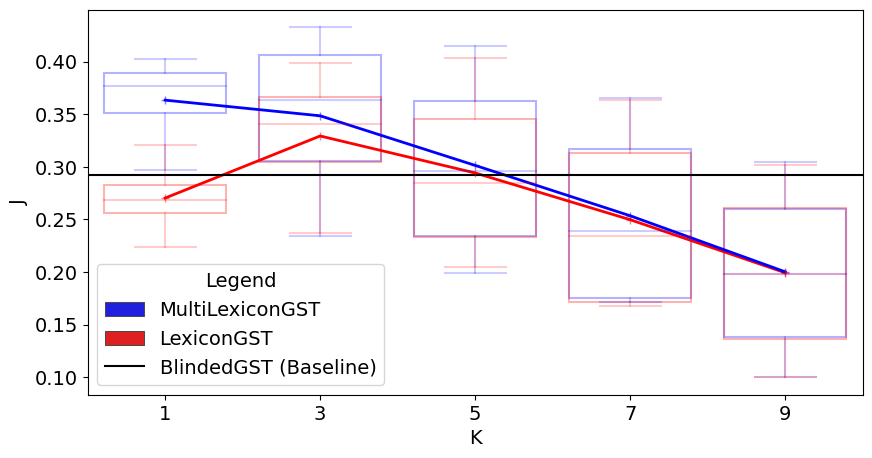

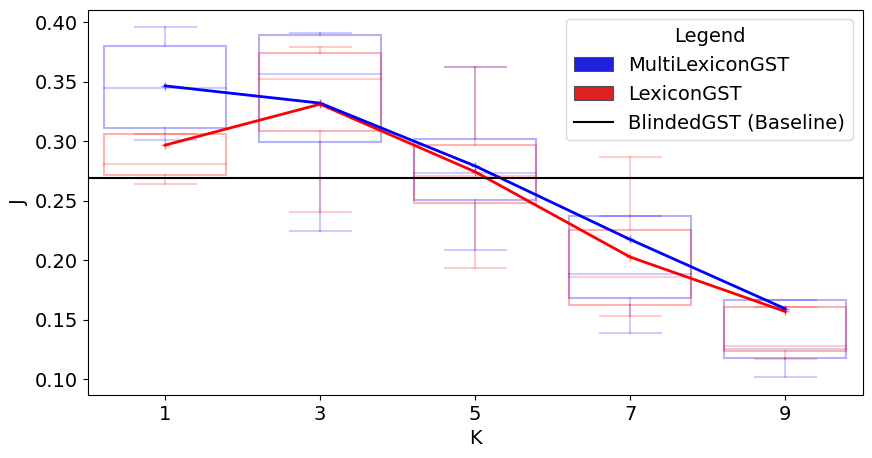

In [61]:
# Plot ONLY J as a function of K for both models (with/without common words) and for a dataset (jigsaw OR paradetox) 
# Plot in the same plot for comparison
data_split = "dev" # "test"
models = ["keep_common_words", "remove_common_words"]
datasets = ["jigsaw", "paradetox"]
metrics = ["J"]
palette = {'MultiLexiconGST': 'blue', 'LexiconGST': 'red'}
plt.rcParams.update({'font.size': 14})

for dataset in datasets:
    frames = []
    baseline_df = pd.read_csv(f"{RESULTS_PATH}/{data_split}/{dataset}/bert_best_head.csv")
    for model in models:
        filepath = f"{RESULTS_PATH}/{data_split}/{dataset}/word_embeddings/{model}.csv"
        if model == "remove_common_words":
            model = "LexiconGST"
        if model == "keep_common_words":
            model = "MultiLexiconGST"
        frames += [load_csv(csv_path=filepath, without_lexicon='ngram-refined').assign(Model=model)]
    plot_metric_vs_k_vs_model(
        metrics=metrics, 
        frames=frames, 
        baseline_df=baseline_df, 
        title=dataset, 
        palette=palette,
        save_path=f"{PLOTS_PATH}/{data_split}/{dataset}/{dataset}_j_vs_k.svg"
    )
